<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [ ]:
seed = np.random.seed(123)

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [ ]:
decomposed = seasonal_decompose(df)

<AxesSubplot:xlabel='datetime'>

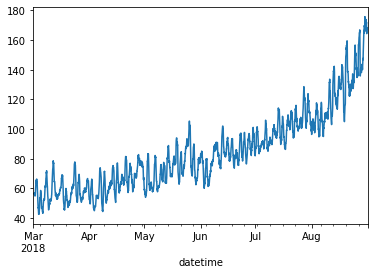

In [ ]:
decomposed.trend.plot(kind='line')

Общий тренд на повышение.Число заказов за время наблюдения (полгода) выросло почти в 3 раза.  
Тренд двигается с ускорением после июня и еще активнее в августе

<AxesSubplot:xlabel='datetime'>

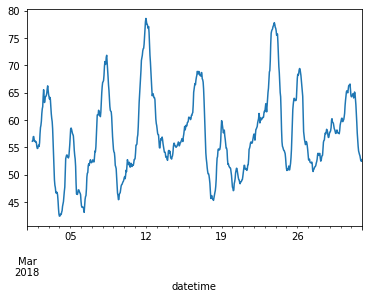

In [ ]:
decomposed.trend['2018-03':'2018-03'] .plot(kind='line')

На внутримесячном тренде видим пики внутри недели - это в основном вечер пятницы и понедельник, а также праздничные дни

<AxesSubplot:xlabel='datetime'>

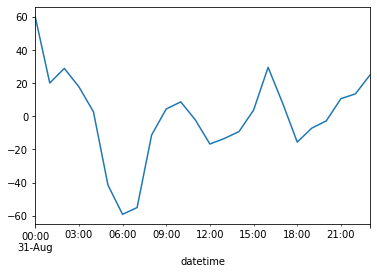

In [ ]:
decomposed.seasonal.tail(24).plot()

Внутри одного дня примерно одинаковая картина - пик в районе 9 часов (начало рабочего дня), около 16 (бранчи? или короткий рабочий день? не уверен), и самый большой - около полуночи.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<AxesSubplot:xlabel='datetime'>

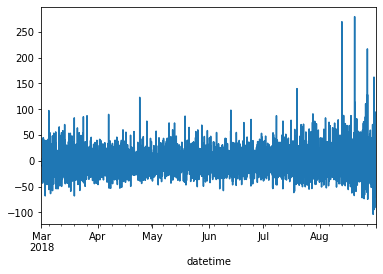

In [ ]:
decomposed.resid.plot()

В конце графика шумы заметно усиливаются, что затруднит работу модели, ведь учиться она будет на тех данных, где шумов меньше.  
Это наверняка отразится на результатах проверки на тестовой выборке.

In [ ]:
def make_features(df, max_lag):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour

    df['lag_168'] = df['num_orders'].shift(168)
    df['lag_336'] = df['num_orders'].shift(336)
    df['lag_504'] = df['num_orders'].shift(554)
    df['lag_672'] = df['num_orders'].shift(672)

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean_24'] = df['num_orders'].shift().rolling(24).mean()
    df['rolling_sum_24'] = df['num_orders'].shift().rolling(24).sum()

    return df

In [ ]:
make_features(df, 48)

,num_orders,day,dayofweek,hour,lag_168,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean_24,rolling_sum_24,lag_336,lag_504,lag_672
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,NaN,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,NaN,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,NaN,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,NaN,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,31,4,19,113.0,207.0,217.0,197.0,116.0,133.0,...,265.0,177.0,170.0,191.0,169.0,164.875000,3957.0,84.0,95.0,91.0
2018-08-31 20:00:00,154,31,4,20,179.0,136.0,207.0,217.0,197.0,116.0,...,216.0,265.0,177.0,170.0,191.0,167.541667,4021.0,126.0,58.0,87.0
2018-08-31 21:00:00,159,31,4,21,166.0,154.0,136.0,207.0,217.0,197.0,...,217.0,216.0,265.0,177.0,170.0,168.041667,4033.0,144.0,96.0,123.0


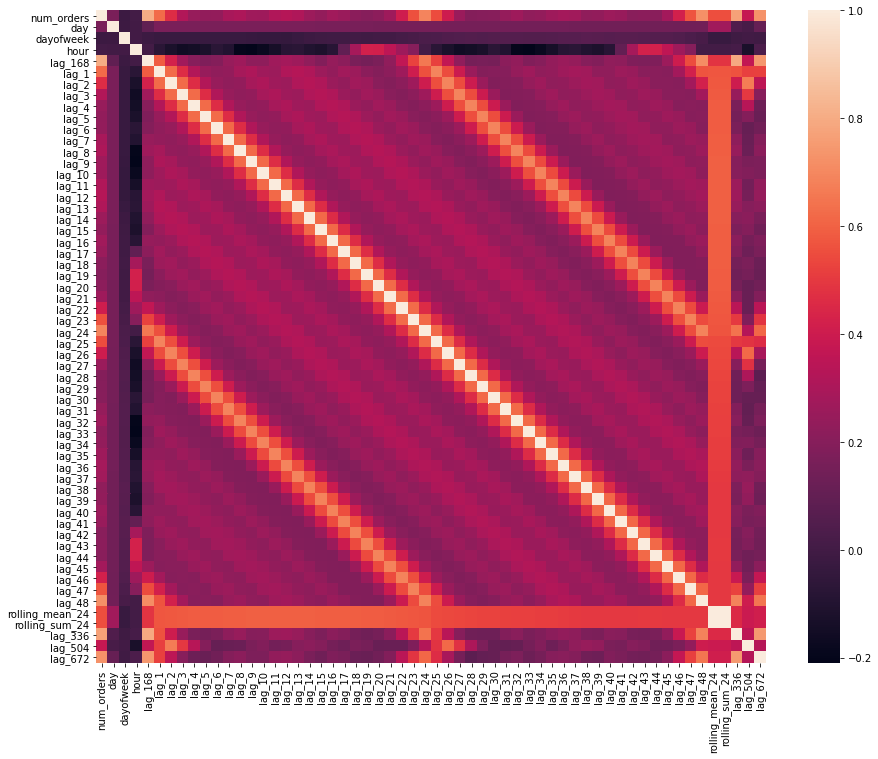

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,12))
fig = sns.heatmap(df.corr(), ax=ax)

Судя по корреляции - основными признаками для модели станут лаги в 24 +-2 часа, среднее скользящее за 24 часа и лаг в 1 неделю (168 часов)

Посмотрим важность признаков другим способом.
Функция показывает, как признак коррелирует с предыдущими. Область синей заливки обозначает порог статистической значимости (если значение внутри, корреляция уже не заслуживает доверия. Статзначимость вычисляется по тесту Стьюдента).

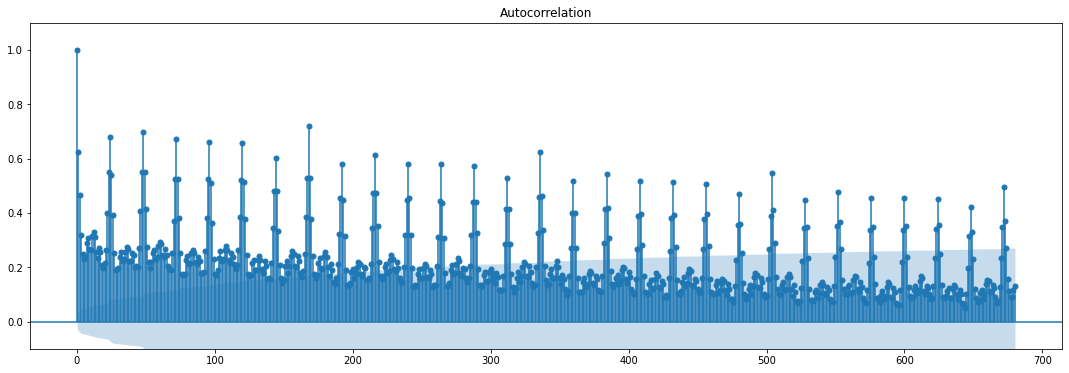

In [ ]:
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 680)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()

## Обучение и тестирование

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']

In [ ]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=5).split(features_train)
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
round(np.mean(-score_lr)**0.5, 2)

CPU times: user 374 ms, sys: 858 ms, total: 1.23 s
Wall time: 1.13 s


22.65

In [ ]:
res_dt = 47
dt = None

for depth in range(4, 7, 1):
    model = DecisionTreeRegressor(random_state=seed, max_depth=depth)
    model.fit(features_train, target_train)
    score_dt = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=5)
    res = round(np.mean(-score_dt)**0.5, 2)
    print(model, res)

    if res < res_dt:
        res_dt = res
        dt = model

DecisionTreeRegressor(max_depth=4) 22.88
DecisionTreeRegressor(max_depth=5) 23.93
DecisionTreeRegressor(max_depth=6) 24.76


In [ ]:
res_rf = 47
rf = None

for depth in range(10, 15, 2):

    model = RandomForestRegressor(random_state=seed, max_depth=depth, n_estimators=100)
    model.fit(features_train, target_train)
    score_rf = cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=3)

    res = round(np.mean(-score_rf)**0.5, 2)
    print(model, res)

    if res < res_rf:
        res_rf = res
        rf = model

RandomForestRegressor(max_depth=10) 20.96
RandomForestRegressor(max_depth=12) 20.93
RandomForestRegressor(max_depth=14) 21.01


In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(test, shuffle=False, test_size=0.5)

train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
features_valid = valid.drop('num_orders', axis = 1)
features_test = test.drop('num_orders', axis = 1)
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

In [ ]:
catboost = CatBoostRegressor(iterations=120, random_seed=seed,
                          learning_rate=0.2,
                        verbose=30,
                          depth=12)

In [ ]:
catboost.fit(features_train, target_train, verbose=30, plot=True)

In [ ]:
cb_rmse = mse(target_valid, catboost.predict(features_valid), squared=False)
cb_rmse

31.146173669176697

In [ ]:
score_cb = cross_val_score(catboost, features_train, target_train, scoring='neg_mean_squared_error', cv=5)
print(catboost, round(np.mean(-score_cb)**0.5, 2))

In [ ]:
lgbm = None
lgbm_rmse = 2500

for depth in range(4,13, 4):
    model = LGBMRegressor(max_depth=depth, n_estimators=100,
                         random_state=seed, learning_rate = 0.3)
    model.fit(features_train, target_train)
    result = mse(target_valid, model.predict(features_valid), squared=False)
    print(model, result)

    if result < lgbm_rmse:
        lgbm = model
        lgbm_rmse = result


LGBMRegressor(learning_rate=0.3, max_depth=4) 29.80053886742697
LGBMRegressor(learning_rate=0.3, max_depth=8) 31.56834506706655
LGBMRegressor(learning_rate=0.3, max_depth=12) 31.46520366522875


## Тестирование

In [ ]:
model_list = [model_lr, dt, rf, catboost, lgbm]

for model in model_list:
    print(f"MSE тестовой выборки {model}:", round(mse(model.predict(features_test), target_test, squared=False), 2))


MSE тестовой выборки LinearRegression(): 33.72
MSE тестовой выборки DecisionTreeRegressor(max_depth=4): 53.54
MSE тестовой выборки RandomForestRegressor(max_depth=12): 41.67
MSE тестовой выборки <catboost.core.CatBoostRegressor object at 0x7fe472fe7df0>: 54.53
MSE тестовой выборки LGBMRegressor(learning_rate=0.3, max_depth=4): 46.85


Проверим результат предсказания предыдущим значением. "Тест адекватности моделей"

In [ ]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
round(mse(pred_previous, target_test, squared=False), 2)

58.88

## Вывод

В ходе исследования проделали следующие шаги:
* Ресемплирование
* Анализ сезонности, общего тренда, тренда внутри дня и недели, шумов
* Добавленение новых признаков (месяц, день, день недели, отстающие показатели, среднее скользящее)
* Оценка важности признаков

Были проверены следующие модели:
* Линейная регрессия  
* Дерево решений  
* Случайный лес  
* Catboost  
* Lightgbm  

Проведенное исследование показало, что наилучшие показатели RMSE у следующей модели:  
**LinearRegression(): 33.72**